# Keras ResNet50

This notebook uses [ResNet50](http://dgschwend.github.io/netscope/#/preset/resnet-50) which is a 50 layer deep neural network. The convolutional layers (so-called feature extrators) are kept while the dense layers are replaced with brand new ones based on new training data. This [transfer learning](http://cs231n.github.io/transfer-learning/) negates the need to build a full NN from scratch.

## References

- [deepsense.ai: Original source](https://github.com/deepsense-ai/Keras-PyTorch-AvP-transfer-learning)
- [pyimagesearch.com: Keras training](https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/)
- [TinyMind: ReLU](https://medium.com/tinymind/a-practical-guide-to-relu-b83ca804f1f7)
- [Keras documentation](https://keras.io/)

# Setup

In [1]:
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# from PIL import Image
import shutil          # move and delete files/folders
import os              # mkdir
from glob import glob  # get contents of folder
import cv2
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
from sklearn.metrics import classification_report

In [2]:
def mkdir(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        # folder was already created ... it's ok
        pass

def rmdir(path):
    try:
        shutil.rmtree(path)
    except FileNotFoundError:
        # folder was already deleted or doesn't exist ... it's ok
        pass

In [3]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from keras.utils import plot_model

Using TensorFlow backend.


In [4]:
keras.__version__

'2.2.4'

# Create Keras data generators 

In [13]:
EPOCHS = 20
BS = 32

train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=BS,
    class_mode='binary',
    target_size=(224,224))

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    'data/validation',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Found 694 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [14]:
# print(dir(validation_generator))
vg = validation_generator
print("validation num labels:{} num images: {} @ {}".format(vg.num_classes, vg.samples, vg.image_shape))
tg = train_generator
print("training num labels:{} num images: {} @ {}".format(tg.num_classes, tg.samples, tg.image_shape))
# print(len(vg.labels))

validation num labels:2 num images: 200 @ (224, 224, 3)
training num labels:2 num images: 694 @ (224, 224, 3)


## Create the NN

We are starting off with the `ResNet50` NN and telling it we are *not* training the base layers (reduces our dataset need and training time). The convolutional layers are the feature detecting layers we are interested in. 

We are also using ReLU as our activation function. ReLU stands for rectified linear unit, and is a type of activation function. Mathematically, it is defined as $y = max(0, x)$, thus all negative numbers are set to 0 while all posative numbers stay whatever value they are. ReLU is a very common activation function. 

1. mathematically cheap
1. converges faster
1. it is sparsely activated (good)
1. however, if it is always stuck on the negative side, then the neuron is dead because it is always 0

The dying ReLU can be fixed with a Leaky ReLU or Parametric ReLU. The leaky varient can sometimes learn faster, but it is not always superior to the normal ReLU.

In [15]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

/Users/kevin/pyvenv/cv/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [16]:
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(2, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [17]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [18]:
# print(H.history.keys())

## Train the model

To train the NN, keras has three functions:

1. `.fit`: for simple datasets that can fit into memory
1. `.fit_generator`: for large datasets too big to fit into memory all at once and/or data augmentation needs to be applied
    1. `steps_per_epoch`: which is the total number of data points divided by the batch size
1. `.train_on_batch`: allows fine grained control of training and data iterator is highly complex

To do this we will have 2 sets of data: training data (`train_datagenerator`) and validation data (`validataion_generator`). The training data will be modified (shear, zoom, flip, etc) while the validation data will be left alone.

In [19]:
history = model.fit_generator(generator=train_generator,
                              epochs=EPOCHS,
                              steps_per_epoch=train_generator.samples/BS,
                              validation_steps=validation_generator.samples/BS,
                              validation_data=validation_generator)


Epoch 1/20
22/21 [==============================] - 159s 7s/step - loss: 0.7298 - acc: 0.6845 - val_loss: 0.3229 - val_acc: 0.8550
Epoch 2/20
22/21 [==============================] - 159s 7s/step - loss: 0.2207 - acc: 0.9192 - val_loss: 0.2807 - val_acc: 0.8850
Epoch 3/20
22/21 [==============================] - 172s 8s/step - loss: 0.1538 - acc: 0.9417 - val_loss: 0.3177 - val_acc: 0.8600
Epoch 4/20
22/21 [==============================] - 200s 9s/step - loss: 0.1351 - acc: 0.9378 - val_loss: 0.1843 - val_acc: 0.9250
Epoch 5/20
22/21 [==============================] - 212s 10s/step - loss: 0.1757 - acc: 0.9241 - val_loss: 0.4019 - val_acc: 0.8450
Epoch 6/20
22/21 [==============================] - 151s 7s/step - loss: 0.0762 - acc: 0.9744 - val_loss: 0.1767 - val_acc: 0.9350
Epoch 7/20
22/21 [==============================] - 153s 7s/step - loss: 0.0662 - acc: 0.9730 - val_loss: 0.1762 - val_acc: 0.9300
Epoch 8/20
22/21 [==============================] - 150s 7s/step - loss: 0.0641 - 

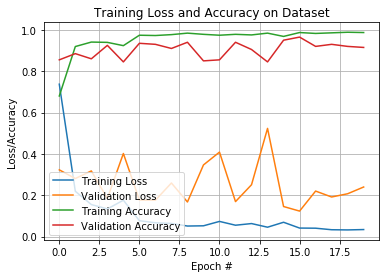

In [20]:
N = EPOCHS
H = history
plt.plot(np.arange(0, N), H.history["loss"], label="Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, N), H.history["acc"], label="Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_acc"], label="Validation Accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.grid(True);
# plt.savefig("plot.png")
# print(classification_report(testLabels.argmax(axis=1), predIdxs,
#     target_names=lb.classes_))

## Save  model

Since training takes a long time, it is very useful to save the model and reload it later. Here is two different ways: python's `pickle` and `HDF5`.

In [21]:
mkdir("models")
mkdir("models/keras")

In [22]:
with open('models/keras/model.pickle', 'wb') as f:
    f.write(pickle.dumps(model, pickle.HIGHEST_PROTOCOL))

In [23]:
# architecture and weights to HDF5
model.save('models/keras/model.h5')

# architecture to JSON, weights to HDF5
# model.save_weights('models/keras/weights.h5')
# with open('models/keras/architecture.json', 'w') as f:
#         f.write(model.to_json())

## Load model

In [ ]:
with open('models/keras/model.pickle', 'rb') as f:
    data = f.read()
model = pickle.loads(data)

In [10]:
# architecture and weights from HDF5
model = load_model('models/keras/model.h5')

# architecture from JSON, weights from HDF5
# with open('models/keras/architecture.json') as f:
#     model = model_from_json(f.read())
# model.load_weights('models/keras/weights.h5')

Instructions for updating:
Use tf.cast instead.


In [33]:
plot_model(model, to_file='model.png')

##  Make predictions on sample test images

In [25]:
validation_img_paths = ["data/validation/alien/21.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [cv2.imread(img_path) for img_path in validation_img_paths]

for i in img_list:
    print(np.array(cv2.resize(i, (224,224)).shape))

[224 224   3]
[224 224   3]
[224 224   3]


In [26]:
validation_batch = np.stack([preprocess_input(np.array(cv2.resize(img, (224,224))))
                             for img in img_list])

In [27]:
pred_probs = model.predict(validation_batch)

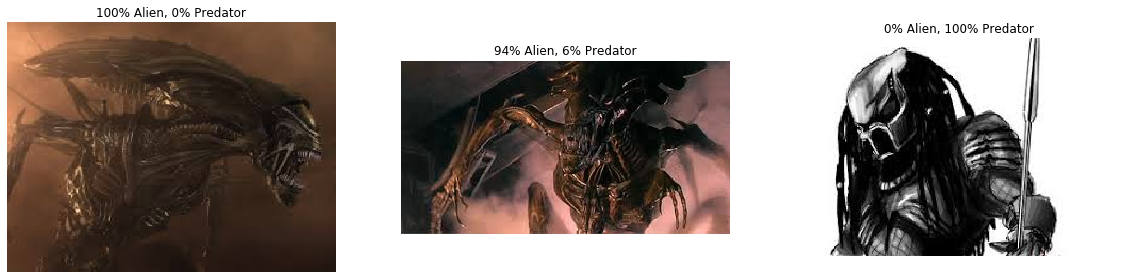

In [28]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Alien, {:.0f}% Predator".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

In [ ]:
# help(ResNet50)

In [ ]:
# help(np.stack)

In [ ]:
# files = glob("data/validation/alien/*.jpg")

In [ ]:
# validation_img_paths = files
# # img_list = [Image.open(img_path) for img_path in validation_img_paths]
# img_list = [cv2.imread(img_path) for img_path in validation_img_paths]

In [ ]:
# validation_batch = np.stack([preprocess_input(np.array(cv2.resize(img, (224,224))))
#                              for img in img_list])

In [ ]:
# pred_probs = model.predict(validation_batch)

## Detection Fails

So nothing is perfect, not even the training and validation datasets. Let's run through the validation datasets and display what isn't identified correctly.

In [34]:
def imshow(f, prob, sz=300):
    """
    Given a filename, display it and print the probability value on it
    """
    img = cv2.imread(f)
    img = cv2.resize(img,(sz,sz))
    cv2.putText(img,prob,(10,sz), cv2.FONT_HERSHEY_SIMPLEX, 4,(0,255,0),8,cv2.LINE_AA)
    plt.imshow(img)
    plt.axis('off')

In [35]:
def run(validation_img_paths, num, threshold=.8):
    """
    threshold: prediction probability an image belongs to a label
    0 - alien
    1 - predator
    """
    img_list = [cv2.imread(img_path) for img_path in validation_img_paths]
    validation_batch = np.stack([preprocess_input(np.array(cv2.resize(img, (224,224))))
                                 for img in img_list])
    pred_probs = model.predict(validation_batch)
    low = []
    perf = []
    for ans, f in zip(pred_probs, files):
        val = ans[num]
        if val < threshold:
            low.append(f)
            perf.append("{:.0f}%".format(100*val))
#         else:
#             print("{:.0f}% Alien, {:.0f}% Predator".format(
#                 100*ans[0],
#                 100*ans[1]))
    print(">> detection {}/{}".format(len(files) - len(low), len(files)))
    r = len(low)//4 + 1
    c = 4
    gs1 = gridspec.GridSpec(r, c)
    gs1.update(wspace=0.025, hspace=0.025)
    for i,f in enumerate(low):
        plt.subplot(gs1[i])
        imshow(f, perf[i])

>> detection 73/100


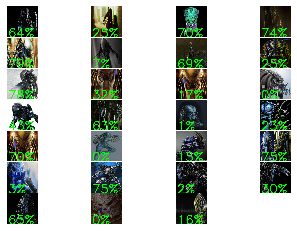

In [31]:
files = glob("data/validation/predator/*.jpg")
run(files,1)

>> detection 96/100


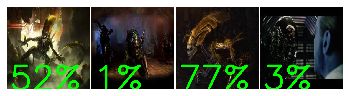

In [36]:
files = glob("data/validation/alien/*.jpg")
run(files,0)